<a href="https://colab.research.google.com/github/abondrn/genetics/blob/master/Genomics_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from datascience import *
import numpy as np
import random
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import scipy.stats as stats
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import scipy.cluster.hierarchy as sch

In [0]:
data = pd.read_csv('https://raw.githubusercontent.com/ds-connectors/Data88-Genetics_and_Genomics/master/Project_data/GSE74923_L1210_CD8_processed_data.txt', sep='\t', index_col=0)
meta_data = pd.read_csv('https://raw.githubusercontent.com/ds-connectors/Data88-Genetics_and_Genomics/master/Project_data/cell_relations.csv').iloc[0:88,:] 
LD = data.iloc[:,:88]

For this lab we will be looking at similarities in gene expression between sister and cousin cells. Our original data set is based on [this publication](https://www.nature.com/articles/ncomms10220). It contains a table containing data obtained after performing scRNA-seq on cells of the same lineage. 

For this project we will only use the first types of cells whose information is contained in the first 88 columns of the original dataset. 

The first thing we did was confirm that the data has been normalized.

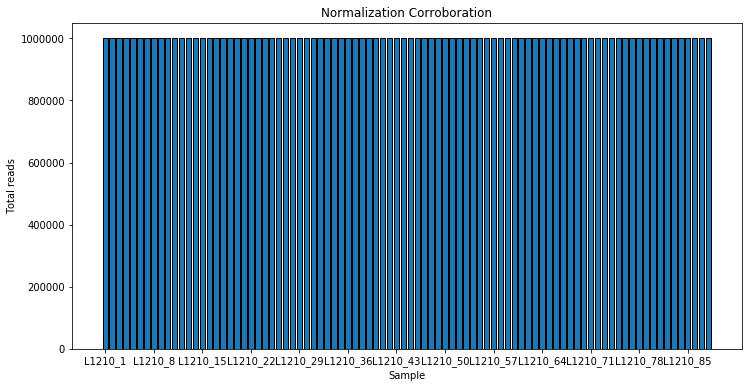

In [51]:
total_counts = np.sum(LD)

bars = list(LD.columns)                    
y_pos = np.arange(len(bars))                            

plt.figure(figsize=(12,6))                       
plt.bar(y_pos, total_counts)   
plt.xticks(y_pos[::7], bars[::7])                          
plt.title('Normalization Corroboration')               
plt.xlabel('Sample')                             
plt.ylabel('Total reads')                        
plt.show()

This plot shows us that the data has been normalized. Thus, we can now more easily manipulate our data to perform the tests that we want to use to visualize and analyze this data.

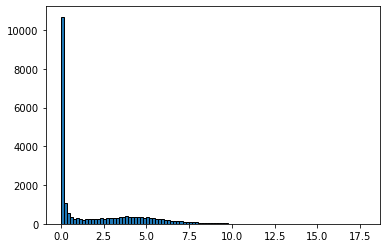

In [11]:
exp_means = np.mean(LD, axis=1)
meaned_log = np.log2(exp_means + 1)
plt.hist(meaned_log, bins=100);

Since our original data is single-cell data, there are a lot of genes that are not expressed by every cell. This is one of the problems that arises with single-cell data. Whereas bulk-data may have at least some expression of every(or most) genes, single-cell data contains a lot of 0 values. In order to account for this, we decided to plot the means of each gene expression into the histogram seen above. However, we wanted to make our data more concise by limiting it to values around the local maximum observed in between 2.5 and 15 on the x-axis. 

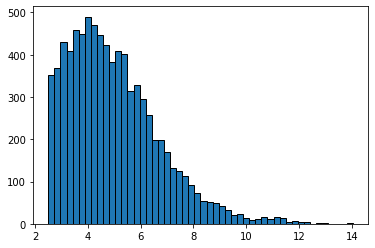

In [12]:
sel = (2.5 < meaned_log) & (meaned_log < 15)
inliers = meaned_log[sel]

plt.hist(inliers, bins = 50);

After filtering our values to this limited range and adjusting the bin size, it is much easier to appreciate the shape of the distribution. Now, to finish filtering our data we want to paralellize these values to our original data set. To do this, we converted the values in the histogram into Boolean Values according to if they exists or not in our meaned_log list.

Now that we have done this we can go ahead and finish filtering our data by selecting the information for which our boolean_values list indicates "True". 

In [0]:
filtered_data = data.loc[sel, :].iloc[:, :88]

Using our filtered data we thought the best way to visualize any clustering patterns amongst the cells was to use tSNE. First, we used PCA. In order for us to do this we used a logarithmic normalization which allowed us to recognize patterns within a visible range while maintaining the relevance of data points such as outliers. Furthermore, the addition of 1 is a method for dealing with data points that might have an initial value of zero. This way we can avoid having zero-values which may interfere with our calculations, and we can also avoid eliminating these values, for they may be relevant to the overall result. 

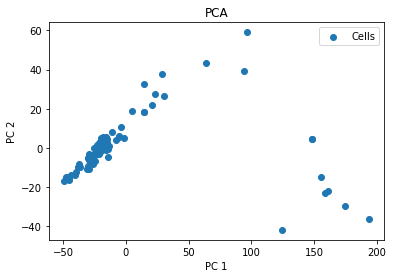

In [14]:
log_df = np.log2(filtered_data + 1)
x = StandardScaler().fit_transform(log_df.T)
pca = PCA(n_components = 20)
principalComponents = pca.fit_transform(x)
plt.scatter(principalComponents[:,0], principalComponents[:,1])
plt.legend(['Cells'])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA')
plt.show()

In [15]:
principalComponents.shape

(88, 20)

Once the PCA was done, we applied the non-linear dimensionality reduction (tSNE) to further visualize our data. 

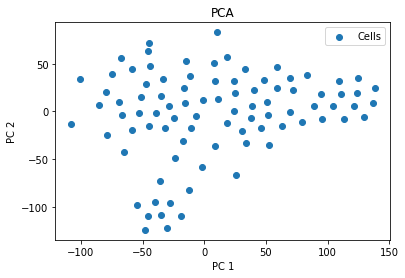

In [16]:
tsne = TSNE(n_components = 2)
X_embedded = tsne.fit_transform(principalComponents)
plt.scatter(X_embedded[:,0], X_embedded[:,1])
plt.legend(['Cells'])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA')
plt.show()

To further visualize the differences in expression between sister cells, cousin cells, and unrelated cells within the selected group of cells, we first converted the expression matrices into distances between each group of cells and stored them into three separate dataframes. 

In order to appreciate this we decided to plot these distances on a boxplot. To do this, we concatenated the distances into one data frame and we then plotted all three cell-type distances into one same graph. 

In [0]:
L_sister_distances = pd.read_csv('https://raw.githubusercontent.com/ds-connectors/Data88-Genetics_and_Genomics/master/Project_data/L_sister_distances.csv')
L_cousin_distances = pd.read_csv('https://raw.githubusercontent.com/ds-connectors/Data88-Genetics_and_Genomics/master/Project_data/L_cousin_distances.csv')
L_unrelated_distances = pd.read_csv('https://raw.githubusercontent.com/ds-connectors/Data88-Genetics_and_Genomics/master/Project_data/L_unr_distances.csv')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


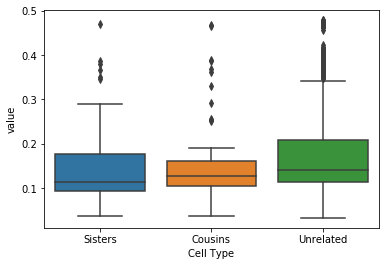

In [43]:
concatenated_dataframes = pd.concat([L_sister_distances.assign(Location = 'Sisters'), L_cousin_distances.assign(Location = 'Cousins'), L_unrelated_distances.assign(Location = 'Unrelated')])
melted_dataframes = pd.melt(concatenated_dataframes, id_vars = ['Location'])
boxplot = sns.boxplot(x = 'Location', y = 'value', data = melted_dataframes)
plt.xlabel('Cell Type')
plt.show()

This is a dendrogram of the cells by euclidean distance. A dendrogram shows the output of a hierarchical clustering algorithm, in this case Ward clustering. When two items are part of the same cluster, they will be linked, and then be treated as a single item going right. The "height" of a linkage is how far apart those items were when they were clustered together.

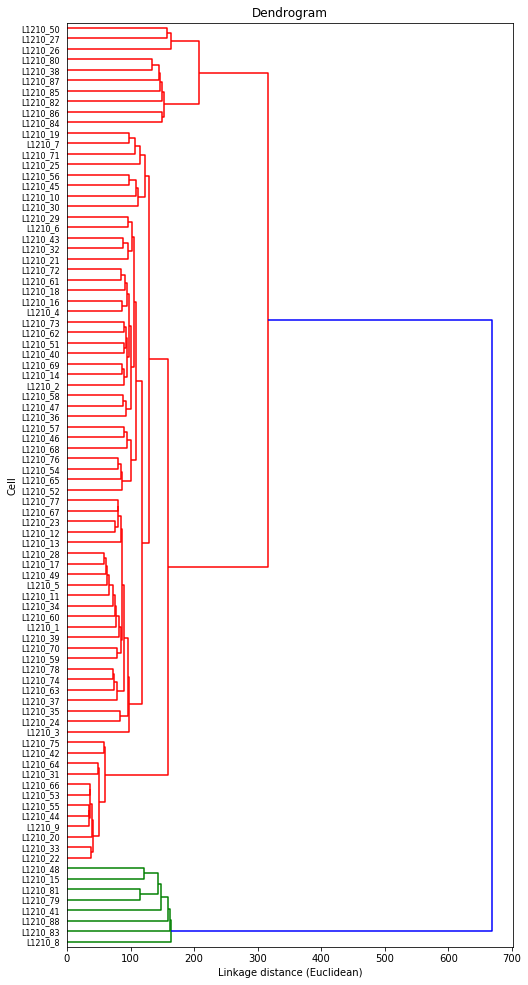

In [83]:
lnk = sch.linkage(x, method = "ward")

plt.figure(figsize=(8,17))
dendrogram = sch.dendrogram(lnk, orientation='right', leaf_font_size=8, labels=filtered_data.columns)
plt.title('Dendrogram')
plt.ylabel('Cell')
plt.xlabel('Linkage distance (Euclidean)')
plt.show()